Program to compare the performance of SGD, Adam and RMS prop optimizers on an iris dataset.

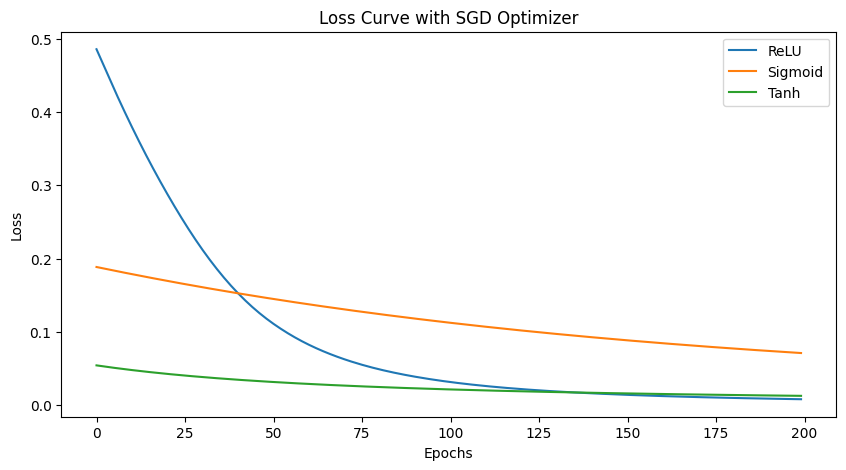

<ipython-input-6-313f92dd8140>:28: RuntimeWarning: overflow encountered in exp
  def sigmoid(x): return 1 / (1 + np.exp(-x))


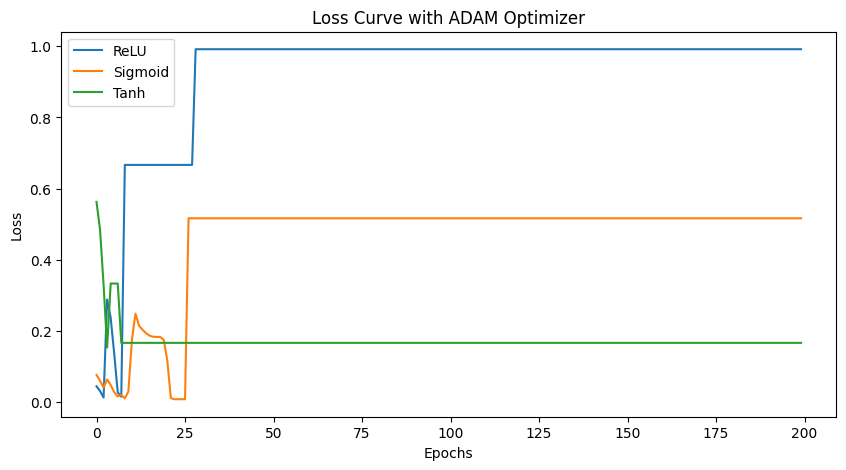

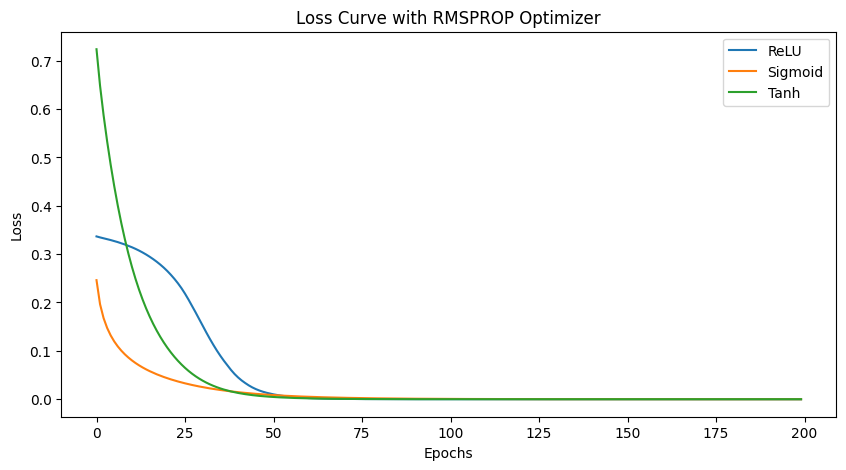

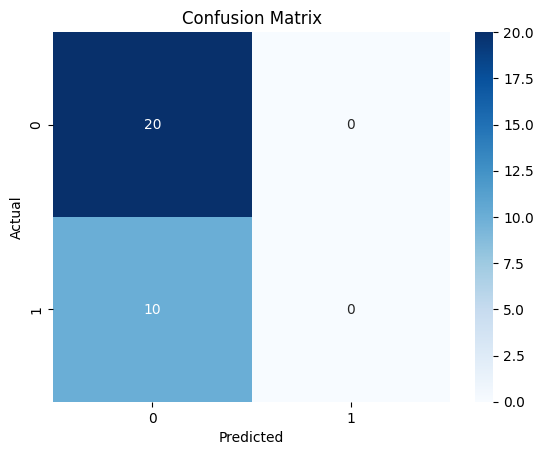

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Binary Classification (Setosa vs. Non-Setosa)
y_binary = (y == 0).astype(int)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Activation Functions
def relu(x): return np.maximum(0, x)
def sigmoid(x): return 1 / (1 + np.exp(-x))
def tanh(x): return np.tanh(x)

# Derivatives
def relu_deriv(x): return (x > 0).astype(float)
def sigmoid_deriv(x): return sigmoid(x) * (1 - sigmoid(x))
def tanh_deriv(x): return 1 - np.tanh(x) ** 2

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, activation, activation_deriv, optimizer='sgd', lr=0.01):
        self.W1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim)
        self.b2 = np.zeros((1, output_dim))
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.optimizer = optimizer
        self.lr = lr
        self.v_w1, self.v_w2, self.v_b1, self.v_b2 = 0, 0, 0, 0  # For momentum-based optimizers
        self.m_w1, self.m_w2, self.m_b1, self.m_b2 = 0, 0, 0, 0  # For Adam
        self.t = 0

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.activation(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = sigmoid(self.z2)  # Output layer activation for binary classification
        return self.a2

    def backward(self, X, y):
        m = y.shape[0]
        dz2 = self.a2 - y.reshape(-1, 1)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = (dz2 @ self.W2.T) * self.activation_deriv(self.z1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        self.update_weights(dW1, db1, dW2, db2)

    def update_weights(self, dW1, db1, dW2, db2):
        if self.optimizer == 'sgd':
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

        elif self.optimizer == 'adam':
            self.t += 1
            beta1, beta2, epsilon = 0.9, 0.999, 1e-8
            self.m_w1 = 0.9 * self.m_w1 + 0.1 * dW1
            self.m_b1 = 0.9 * self.m_b1 + 0.1 * db1
            self.m_w2 = 0.9 * self.m_w2 + 0.1 * dW2
            self.m_b2 = 0.9 * self.m_b2 + 0.1 * db2
            v_w1 = 0.999 * self.v_w1 + 0.001 * (dW1 ** 2)
            v_b1 = 0.999 * self.v_b1 + 0.001 * (db1 ** 2)
            v_w2 = 0.999 * self.v_w2 + 0.001 * (dW2 ** 2)
            v_b2 = 0.999 * self.v_b2 + 0.001 * (db2 ** 2)
            self.W1 -= self.lr * self.m_w1 / (np.sqrt(v_w1) + epsilon)
            self.b1 -= self.lr * self.m_b1 / (np.sqrt(v_b1) + epsilon)
            self.W2 -= self.lr * self.m_w2 / (np.sqrt(v_w2) + epsilon)
            self.b2 -= self.lr * self.m_b2 / (np.sqrt(v_b2) + epsilon)

        elif self.optimizer == 'rmsprop':
            beta, epsilon = 0.9, 1e-8
            self.v_w1 = beta * self.v_w1 + (1 - beta) * (dW1 ** 2)
            self.v_b1 = beta * self.v_b1 + (1 - beta) * (db1 ** 2)
            self.v_w2 = beta * self.v_w2 + (1 - beta) * (dW2 ** 2)
            self.v_b2 = beta * self.v_b2 + (1 - beta) * (db2 ** 2)
            self.W1 -= self.lr * dW1 / (np.sqrt(self.v_w1) + epsilon)
            self.b1 -= self.lr * db1 / (np.sqrt(self.v_b1) + epsilon)
            self.W2 -= self.lr * dW2 / (np.sqrt(self.v_w2) + epsilon)
            self.b2 -= self.lr * db2 / (np.sqrt(self.v_b2) + epsilon)

    def train(self, X, y, epochs=100):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = np.mean((y - y_pred.flatten()) ** 2)
            losses.append(loss)
            self.backward(X, y)
        return losses

# Testing with different optimizers
optimizers = ['sgd', 'adam', 'rmsprop']
activation_funcs = {'ReLU': (relu, relu_deriv), 'Sigmoid': (sigmoid, sigmoid_deriv), 'Tanh': (tanh, tanh_deriv)}

for optimizer in optimizers:
    plt.figure(figsize=(10, 5))
    for name, (act, act_deriv) in activation_funcs.items():
        nn = NeuralNetwork(4, 8, 1, act, act_deriv, optimizer=optimizer, lr=0.01)
        losses = nn.train(X_train, y_train, epochs=200)
        plt.plot(losses, label=f'{name}')
    plt.title(f'Loss Curve with {optimizer.upper()} Optimizer')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Confusion Matrix for the best performing model
best_nn = NeuralNetwork(4, 8, 1, relu, relu_deriv, optimizer='adam')
best_nn.train(X_train, y_train, epochs=200)
y_pred = (best_nn.forward(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
